# Spectrum Holding Summary Document

Code within notebook tests the shapefile processing to present as human-readable summaries of client number extracts.

In [1]:

# -------------------- WORKING DOCUMENT SETUP ------------------------
import rrl
import HCIS
import geopandas as gpd
import pandas as pd

data = rrl.readSpecData()
asmg = gpd.read_file('ASMG/asmg.shp')
asmg.to_csv('debug.csv')

In [2]:
# -------------------- TEST EXTRACT ------------------------
clientData = rrl.clientSearch(data, "1104504,20009217")
clientData = clientData.iloc[[6,7]]
test = rrl.buildgdf(clientData, asmg)
test


,LICENCE_NO,CLIENT_NO,LFREQ_START,LWFREQ_END,HIFREQ_START,HIFREQ_END,LW_BW,HI_BW,BANDWIDTH,AREA_CODE,AREA_NAME,HCIS,geometry
0,10143466,1104504,1935000000,1940000000,2.125000e+09,2.130000e+09,5000000,5000000.0,10000000.0,AP_10143466_4114,Perth,"BV1I, BV1J, BV1K, BV1L, BV1M, BV1N, BV1O, BV1P...","POLYGON ((115.16816 -32.83215, 115.08483 -32.8..."
1,10143466,1104504,1965000000,1975000000,2.155000e+09,2.165000e+09,10000000,10000000.0,20000000.0,AP_10143466_4124,Regional Western Australia,"AU2, AU3, AU6, AU9, AV9, AW3, BU1, BU2, BU4, B...","POLYGON ((114.83486 -34.99884, 114.75153 -34.9..."


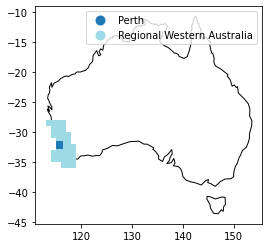

In [3]:
import contextily as cx
from matplotlib import pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'Australia'].plot(color='white', edgecolor='black')
fig = test.plot(ax=ax, column='AREA_NAME', cmap='tab20', categorical=True, legend=True)

c:\Users\navni\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:2352: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<AxesSubplot:>

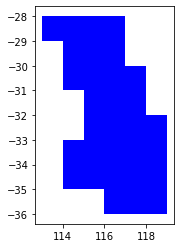

In [4]:
test = (test.iloc[[0]]).overlay(test.iloc[[1]], how='intersection')
test.plot(color="b")


## Geometric Approach to Unique Area Identification

Use geometric operations to create 

## Unique Area Function

The most challenging part of generating a holding summary is being able to remove overlapping HCIS cells from each area description entry. Removing overlapping HCIS cells is necessary to produce a two dimensional, human readable dataset.

In [ ]:

def getUniqueAreas(gdf):
    """Given a geodataframe, return a list of unique HCIS descriptions

    Args:
        gdf (GeoDataFrame): Client data geodataframe

    Returns:
        uniqueArea s: List of HCIS descriptions (list)
    """

    # Function Setup
    areaStrings = gdf['AREA_DESCRIPTION'].tolist()
    uniqueAreas = []

    for string in areaStrings:
        uniqueAreas.append(list(string.split(', ')))

    newAreas = []
    i = 0
    
    # Loop through every hcis for comparison
    for hcis1 in uniqueAreas:
        
        j = 0
        
        for hcis2 in uniqueAreas:
            
            # Ensure comparison of different HCIS cells
            if i != j:
                
                union = set(hcis1).intersection(set(hcis2))
                
                # If union is 0, there aren't any matches
                if len(union) == 0:
                    j = j + 1
                    continue
                
                # Duplicate HCIS
                elif set(hcis1) == union:
                    uniqueAreas.pop(j)
                    
                else:
                    newAreas.append(list(union))
                    uniqueAreas[i] = list(set(hcis1) - union)
                    uniqueAreas[j] = list(set(hcis2) - union)
                    
            j = j + 1
            
        i = i + 1

    uniqueAreas.append(newAreas)
    return uniqueAreas

uniqueAreas = getUniqueAreas(shp)
#print(uniqueAreas)

In [ ]:
# Loop testing

newAreas = []
i = 0
# Loop through every hcis for comparison
for hcis1 in uniqueAreas:
    
    j = 0
    
    for hcis2 in uniqueAreas:
        
        # Ensure comparison of different HCIS cells
        if i != j:
            
            union = set(hcis1).intersection(set(hcis2))
            
            # If union is 0, there aren't any matches
            if len(union) == 0:
                j = j + 1
                continue
            
            # Duplicate HCIS
            elif set(hcis1) == union:
                uniqueAreas.pop(j)
                
            else:
                newAreas.append(list(union))
                uniqueAreas[i] = list(set(hcis1) - union)
                uniqueAreas[j] = list(set(hcis2) - union)
                
        j = j + 1
        
    i = i + 1

uniqueAreas.append(newAreas)

uniqueAreas = getUniqueAreas(shp)
print(unique)

## Spectrum Holdings Builder

Using unique area descriptions and client number extract, a new dataset must be constructed summarising holdings for a given unique area description.

In [ ]:
# build gdf from unique areas
bands = set(specLicence['LICENCE_CATEGORY_NAME'])
bands

holdings = pd.DataFrame({
    "HCIS" : [],
    'Total BW' : [],
    '1800 MHz Band' : [],
    '2 GHz Band' : [],
    '2.3 GHz Band' : [],
    '2.5 GHz Band' : [],
    '2.5 GHz Mid Band Gap' : [],
    '20 GHz Defence Band' : [],
    '26 GHz Band' : [],
    '3.4 GHz Band' : [],
    '30 GHz Defence Band' : [],
    '700 MHz Band' : [],
    '800 MHz Band' : [],
    'AWL - FSS Only' : [],
    'AWL - Standard' : []
})
holdings

In [ ]:
# ------------------------------------------------------
# -------- Build holdings helper functions -------------
# ------------------------------------------------------

def intersection (HCIS, row):
    """Returns list of HCIS that is in both input HCIS list and input row.

    Args:
        HCIS (List): List of HCIS identifiers.
        row (Dataframe Row): Row from a client dataframe or shapefile.

    Returns:
        isin (List): List of HCIS identifiers in both inputs.
    """
    temp = set(row['AREA_DESCRIPTION'])
    isin = [value for value in HCIS if value in temp]
    return isin

def removeHCIS (AreaDescription, uaHCIS):
    newHCIS = []
    return newHCIS

def updateHoldings (row, holdings, uaHCIS):
    return

HCIS = uniqueAreas[-1]
print(HCIS)

In [ ]:
# ------------------------------------------------------
# -------- Build holdings primary function -------------
# ------------------------------------------------------

def buildHoldings (uniqueAreas, shp):
    """Given a list of unique area defined by HCIS sequences 
    and a geodataframe, generate a holdings summary.

    Args:
        uniqueAreas (List of Lists): List containing unique HCIS sequences
        shp (Geodataframe): Client Data geodataframe

    Returns:
        holdings: Holdings summary geodataframe
    """
    
    # Create empty dataset
    holdings = pd.DataFrame({
    "HCIS" : [],
    'Total BW' : [],
    '1800 MHz Band' : [],
    '2 GHz Band' : [],
    '2.3 GHz Band' : [],
    '2.5 GHz Band' : [],
    '2.5 GHz Mid Band Gap' : [],
    '20 GHz Defence Band' : [],
    '26 GHz Band' : [],
    '3.4 GHz Band' : [],
    '30 GHz Defence Band' : [],
    '700 MHz Band' : [],
    '800 MHz Band' : [],
    'AWL - FSS Only' : [],
    'AWL - Standard' : []
    })
    
    for uaHCIS in uniqueAreas:
        
        for index, row in shp.iterrows():
            
            isin = intersection(uaHCIS, row)
            
            # If uaHCIS is in entry[HCIS]
            if len(isin) != 0:
                
                shp.at[index]['LICENCE_AREA_DESCRIPTION'] = removeHCIS(shp.iloc[index]['LICENCE_AREA_LOCATION'], uaHCIS)
                
                updateHoldings = (row, holdings, uaHCIS)
            
            else:
                
                continue
            
    return holdings